# PUBG 생존자 예측 모델링

## 데이터 설명

File descriptions
- train_V2.csv - the training set 
- test_V2.csv - the test set 
- sample_submission_V2.csv - a sample submission file in the correct format


Data fields

- DBNOs - (적을 기절시켰으나, 적 팀원에 의해 부활되어 실제로는 킬로 처리되지 않은 횟수)
- assists - (어시스트 수)
- boosts - (사용된 부스트 아이템 수)
- damageDealt - (가한 총 피해량 - 자기자신에게 가한 데미지는 제외)
- headshotKills - ( 헤드샷으로 사망한 적 플레이어의 수)
- heals - (사용된 치유 아이템 수)
- Id -         (플레이어 아이디)
- killPlace - (경기에서 처치한 적의 수 랭킹)
- killPoints - (플레이어 처치 기반 외부 랭킹(Elo 방식), rankpoint에서 -1이 아닌 값이 있는 경우, killpoints에서 0은 '없음'으로 처리되어야 한다)
- killStreaks - (짧은 시간에 죽인 적 플레이어의 최대 수)
- kills - (죽인 적 플레이어의 수)
- longestKill - (사망 시 사망한 플레이어와 플레이어 사이의 최장거리. 플레이어를 죽이고 차를 몰고 가면 가장 긴 킬 통계가 나올 수 있으므로 오해의 소지가 있음)
- matchDuration -  (일치 시간(초))
- matchId -  (일치를 식별하는 아이디)
- matchType -  (게임모드:솔로,듀오,스쿼드 등등)
- rankPoints - (플레이어의 Elo와 같은 순위 - 다음 API 버전에서는 삭제될 예정 -1 값은 '없음'을 대신함)
- revives - (소생시킨 횟수)
- rideDistance -  (미터 단위의 차량의 총 이동거리)
- roadKills -  (차량으로 죽인 횟수)
- swimDistance - (미터 단위의 수영 거리)
- teamKills -  (팀원 킬 수)
- vehicleDestroys -  (차량을 폭발시킨 횟수)
- walkDistance -  (미터 단위 총 도보 거리)
- weaponsAcquired -  (획득한 무기의 수)
- winPoints - (플레이어의 승리 기반 외부 랭킹(Elo 방식의 순위). rankpoint에서 -1이 아닌 값이 있는 경우, winpoints에서 0은 '없음'으로 처리)
- groupId -  (경기 내의 그룹을 식별하는 ID. 현재 그룹의 선수들이 다른 경기를 한다면 다른 ID를 갖게됨)
- numGroups - (경기에 있는 그룹의 수)
- maxPlace - (경기에서 가장 순위가 낮은 것에 대한 데이터. 순위를 건너뛸 수 있기에 numgroups와 일치하지 않을 수 있음)
- **winPlacePerc** - (예측 대상. 백분위수 승리 배치로 1은 1위, 0은 경기에서 꼴지했다는것. 이건 numgroups로 계산되는게 아니라, maxPlace로 계산되기 때문에 누락되는 것이 있을 수도 있음)

## Library

In [40]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
import warnings
warnings.filterwarnings(action='ignore')
import sys
import os

## data

In [19]:
train = pd.read_csv('./pubg-finish-placement-prediction/train_V2.csv')
test = pd.read_csv('./pubg-finish-placement-prediction/test_V2.csv')


In [21]:
# Memory saving function credit to https: // www.kaggle.com/gemartin/load-data-reduce-memory-usage


def reduce_mem_usage(df):
    """ iterate through all the columns of a dataframe and modify the data type
        to reduce memory usage.        
    """
    #start_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage of dataframe is {:.2f} MB'.format(start_mem))

    for col in df.columns:
        col_type = df[col].dtype

        if col_type != object:
            c_min = df[col].min()
            c_max = df[col].max()
            if str(col_type)[:3] == 'int':
                if c_min > np.iinfo(np.int8).min and c_max < np.iinfo(np.int8).max:
                    df[col] = df[col].astype(np.int8)
                elif c_min > np.iinfo(np.int16).min and c_max < np.iinfo(np.int16).max:
                    df[col] = df[col].astype(np.int16)
                elif c_min > np.iinfo(np.int32).min and c_max < np.iinfo(np.int32).max:
                    df[col] = df[col].astype(np.int32)
                elif c_min > np.iinfo(np.int64).min and c_max < np.iinfo(np.int64).max:
                    df[col] = df[col].astype(np.int64)
            else:
                if c_min > np.finfo(np.float16).min and c_max < np.finfo(np.float16).max:
                    df[col] = df[col].astype(np.float16)
                elif c_min > np.finfo(np.float32).min and c_max < np.finfo(np.float32).max:
                    df[col] = df[col].astype(np.float32)
                else:
                    df[col] = df[col].astype(np.float64)

    #end_mem = df.memory_usage().sum() / 1024**2
    #print('Memory usage after optimization is: {:.2f} MB'.format(end_mem))
    #print('Decreased by {:.1f}%'.format(100 * (start_mem - end_mem) / start_mem))

    return df


train = reduce_mem_usage(train)
test = reduce_mem_usage(test)


In [22]:
train.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [23]:
test.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,rankPoints,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints
0,9329eb41e215eb,676b23c24e70d6,45b576ab7daa7f,0,0,51.46875,0,0,0,73,...,1500,0,0.0,0,0.0,0,0,588.0,1,0
1,639bd0dcd7bda8,430933124148dd,42a9a0b906c928,0,4,179.12500,0,0,2,11,...,1503,2,4668.0,0,0.0,0,0,2017.0,6,0
2,63d5c8ef8dfe91,0b45f5db20ba99,87e7e4477a048e,1,0,23.40625,0,0,4,49,...,1565,0,0.0,0,0.0,0,0,788.0,4,0
3,cf5b81422591d1,b7497dbdc77f4a,1b9a94f1af67f1,0,0,65.50000,0,0,0,54,...,1465,0,0.0,0,0.0,0,0,1812.0,3,0
4,ee6a295187ba21,6604ce20a1d230,40754a93016066,0,4,330.25000,1,2,1,7,...,1480,1,0.0,0,0.0,0,0,2964.0,4,0


In [24]:
train.shape, test.shape

((4446966, 29), (1934174, 28))

In [25]:
# null 값 확인
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       1
dtype: int64

- winPlacePerc 하나가 누락된 것을 확인

In [26]:
train[train['winPlacePerc'].isnull()]

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
2744604,f70c74418bb064,12dfbede33f92b,224a123c53e008,0,0,0.0,0,0,0,1,...,0,0.0,0,0.0,0,0,0.0,0,0,NaN


In [27]:
# winPlacePerc가 결측치인 2744604번을 drop
train.drop(2744604, inplace=True)

In [28]:
train.isnull().sum()

Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
winPlacePerc       0
dtype: int64

In [29]:
test.isnull().sum()


Id                 0
groupId            0
matchId            0
assists            0
boosts             0
damageDealt        0
DBNOs              0
headshotKills      0
heals              0
killPlace          0
killPoints         0
kills              0
killStreaks        0
longestKill        0
matchDuration      0
matchType          0
maxPlace           0
numGroups          0
rankPoints         0
revives            0
rideDistance       0
roadKills          0
swimDistance       0
teamKills          0
vehicleDestroys    0
walkDistance       0
weaponsAcquired    0
winPoints          0
dtype: int64

## EDA

In [30]:
df = train.copy()
df.head()

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244.75,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434.00,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161.75,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202.75,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49.75,2,0,0.187500


In [31]:
df.columns

Index(['Id', 'groupId', 'matchId', 'assists', 'boosts', 'damageDealt', 'DBNOs',
       'headshotKills', 'heals', 'killPlace', 'killPoints', 'kills',
       'killStreaks', 'longestKill', 'matchDuration', 'matchType', 'maxPlace',
       'numGroups', 'rankPoints', 'revives', 'rideDistance', 'roadKills',
       'swimDistance', 'teamKills', 'vehicleDestroys', 'walkDistance',
       'weaponsAcquired', 'winPoints', 'winPlacePerc'],
      dtype='object')

### 이상치 제거

#### 움직이지 않았지만 무기를 소지한 플레이어 제거


In [32]:
df['walkDistance'] = df['walkDistance'].astype('int')

In [33]:
# 2만여개 정도
df_out = df[(df['walkDistance'] == 0) & (df['weaponsAcquired'] > 0)].index

In [34]:
df = df.drop(df_out)
df

,Id,groupId,matchId,assists,boosts,damageDealt,DBNOs,headshotKills,heals,killPlace,...,revives,rideDistance,roadKills,swimDistance,teamKills,vehicleDestroys,walkDistance,weaponsAcquired,winPoints,winPlacePerc
0,7f96b2f878858a,4d4b580de459be,a10357fd1a4a91,0,0,0.00000,0,0,0,60,...,0,0.000000,0,0.000000,0,0,244,1,1466,0.444336
1,eef90569b9d03c,684d5656442f9e,aeb375fc57110c,0,0,91.50000,0,0,0,57,...,0,0.004501,0,11.039062,0,0,1434,5,0,0.640137
2,1eaf90ac73de72,6a4a42c3245a74,110163d8bb94ae,1,0,68.00000,0,0,0,47,...,0,0.000000,0,0.000000,0,0,161,2,0,0.775391
3,4616d365dd2853,a930a9c79cd721,f1f1f4ef412d7e,0,0,32.90625,0,0,0,75,...,0,0.000000,0,0.000000,0,0,202,3,0,0.166748
4,315c96c26c9aac,de04010b3458dd,6dc8ff871e21e6,0,0,100.00000,0,0,0,45,...,0,0.000000,0,0.000000,0,0,49,2,0,0.187500
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4446961,afff7f652dbc10,d238e426f50de7,18492834ce5635,0,0,0.00000,0,0,0,74,...,0,1292.000000,0,0.000000,0,0,1019,3,1507,0.178589
4446962,f4197cf374e6c0,408cdb5c46b2ac,ee854b837376d9,0,1,44.15625,0,0,0,69,...,0,0.000000,0,0.000000,0,0,81,6,0,0.293457
4446963,e1948b1295c88a,e26ac84bdf7cef,6d0cd12784f1ab,0,0,59.06250,0,0,0,66,...,0,0.000000,0,2.183594,0,0,788,4,0,0.481445
4446964,cc032cdd73b7ac,c2223f35411394,c9c701d0ad758a,0,4,180.37500,1,1,2,11,...,2,0.000000,0,0.000000,0,0,2748,8,0,0.799805


### 예측 목표인 winPlacePerc와 각 컬럼들의 관계

<AxesSubplot:>

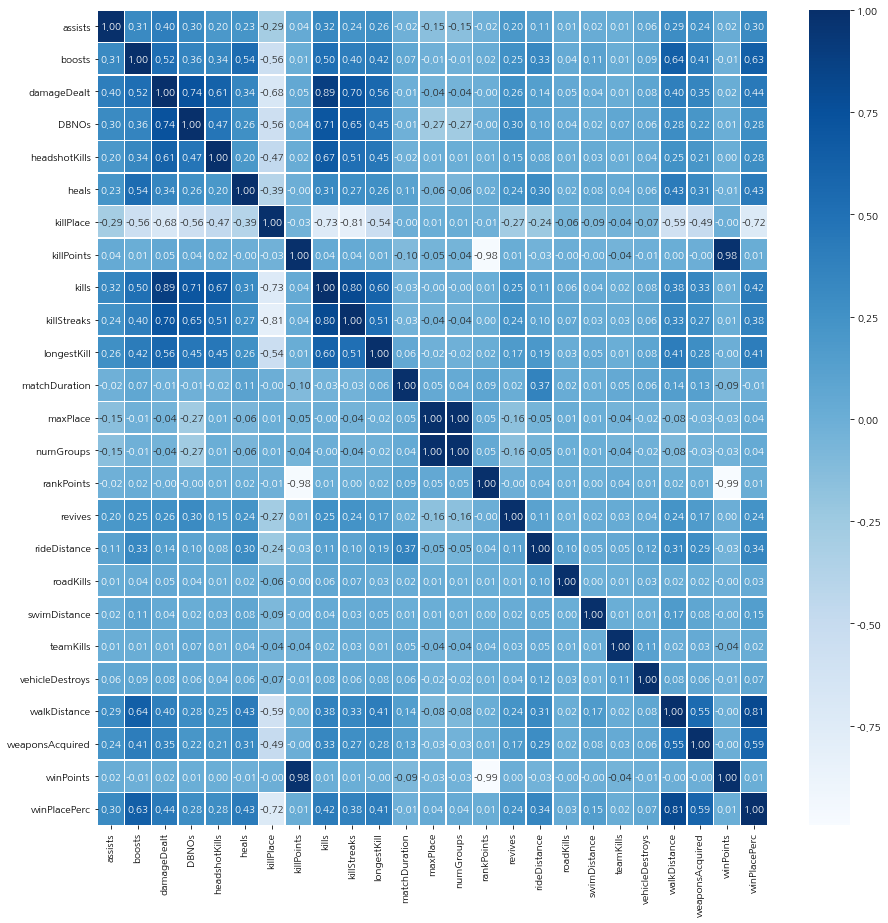

In [35]:
plt.figure(figsize=(15, 15))
sns.heatmap(data=df.corr(), annot=True,
            fmt='.2f', linewidths=.5, cmap='Blues')


- winPlacePerc에 영향을 주는 컬럼
- [DBNOs, assists, boosts, damage Dealt, headshotKills, heals, kills, killStreaks, longestKil,
 revives, rideDistance, swimDistance, walkDistance, weaponsAcquired]
- 그 중에서도 walkDistance, boosts, weaponsAcquired가 높은 것을 확인할 수 있음

In [36]:
# 시각화 함수
def plot_counts(p):
    plt.figure(figsize=(20, 16))
    sns.countplot(df[p]).set_title(p)
    plt.show()

### 매치 수

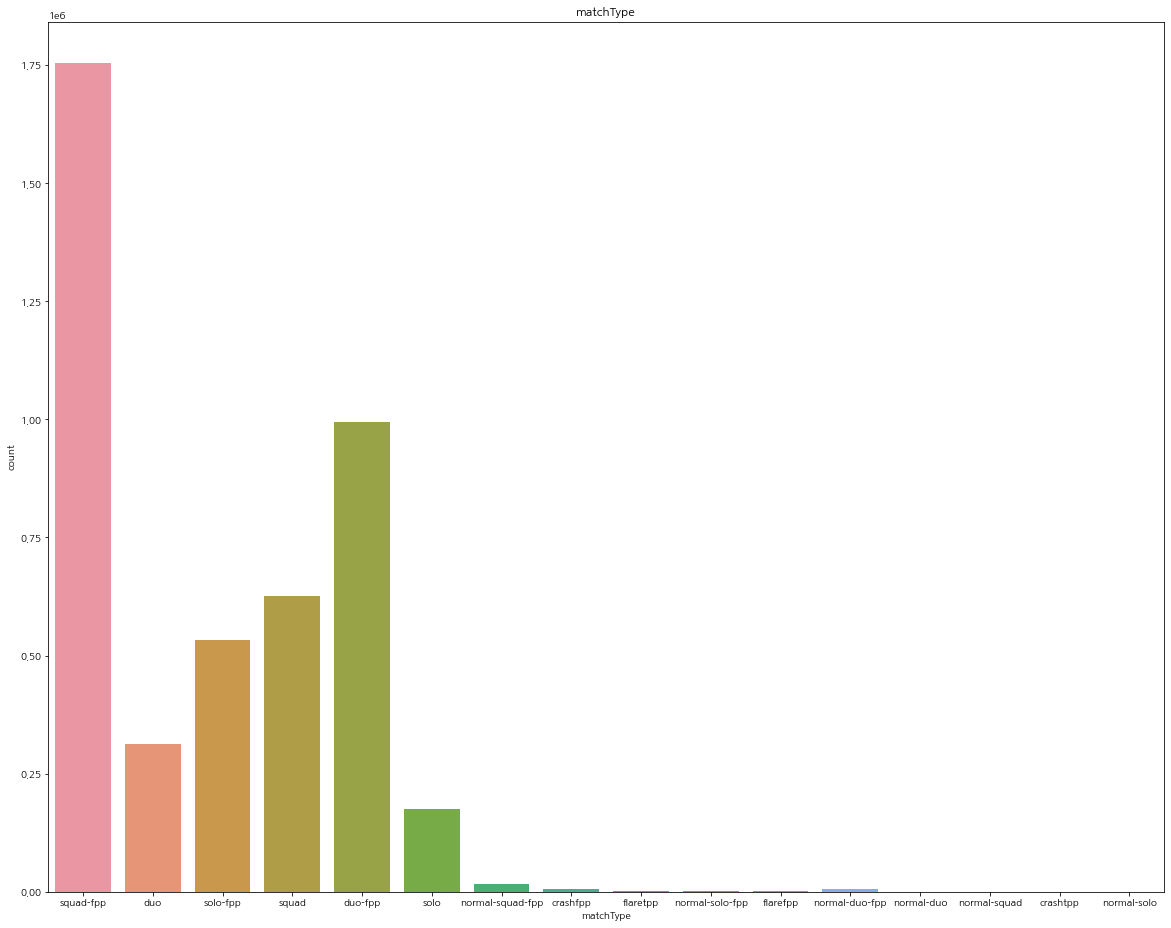

In [37]:
plot_counts('matchType')

In [38]:
df['matchType'].value_counts()

squad-fpp           1752791
duo-fpp              994583
squad                625648
solo-fpp             531789
duo                  313116
solo                 174601
normal-squad-fpp      15904
crashfpp               6286
normal-duo-fpp         5388
flaretpp               2505
normal-solo-fpp        1466
flarefpp                717
normal-squad            437
crashtpp                371
normal-solo             276
normal-duo              190
Name: matchType, dtype: int64

- squad-fpp (스쿼드 1인칭) 모드가 가장 많고, duo-fpp, squad, solo-fpp 모드 순으로 많음
- 외외로 fpp(1인칭 모드)가 많은 것을 볼 수 있음

In [39]:
df.groupby('matchType')['kills'].mean().sort_values(ascending=False)


matchType
normal-solo         7.547101
normal-solo-fpp     7.352660
normal-squad        5.135011
normal-duo          3.705263
normal-squad-fpp    3.063946
normal-duo-fpp      1.872494
solo-fpp            0.943203
duo-fpp             0.928019
squad-fpp           0.910123
duo                 0.909328
solo                0.907469
squad               0.892671
flarefpp            0.887029
crashtpp            0.881402
flaretpp            0.857485
crashfpp            0.779192
Name: kills, dtype: float64

- normal을 제외하면 미세하지만 fpp가 평균 킬 수가 더 많음

## Linear Regression

In [41]:
from sklearn.metrics import mean_squared_error
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import GridSearchCV

In [42]:
le = LabelEncoder()
train['matchType'] = le.fit_transform(train['matchType'])
test['matchType'] = le.fit_transform(test['matchType'])


In [44]:
X_train = train.drop(['winPlacePerc','Id','matchId','groupId'],axis=1)
y_train = np.array(train['winPlacePerc'])
y_train = y_train.reshape(4446965, 1)


In [45]:
model = LinearRegression()
model = model.fit(X_train, y_train)
pred = model.predict(X_train)

In [46]:
rmse = np.sqrt(mean_squared_error(y_train, pred))
r_sq = model.score(X_train, y_train)
print(r_sq)
print(rmse)

0.8318100245283424
0.1260752900347654


In [47]:
pubg_test = test.drop(['Id', 'matchId', 'groupId'], axis=1)
test_predict = model.predict(pubg_test)
print(test_predict)


[[0.18754718]
 [0.91069397]
 [0.43957909]
 ...
 [0.80193747]
 [0.75616312]
 [0.01963329]]


In [48]:
parameters = {'fit_intercept': [True, False], 'normalize': [
    True, False], 'copy_X': [True, False]}
grid = GridSearchCV(model, parameters, cv=4)
grid.fit(X_train, y_train)
print("The tuned R_square value:")
print(grid.best_score_)


The tuned R_square value:
0.8317938360514163
